In [169]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


from PIL import Image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC


import cv2

# Data Visualization

In [170]:
pneumonia_dir = 'Resources/train/PNEUMONIA/'
normal_dir = 'Resources/train/NORMAL/'
# load images from pneumonia folder
pneumonia_images = [os.path.join(pneumonia_dir, img) for img in os.listdir(pneumonia_dir)]
# load images from normal folder
healthy_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
print(pneumonia_images)
print(healthy_images)

['Resources/train/PNEUMONIA/person1000_bacteria_2931.jpeg', 'Resources/train/PNEUMONIA/person1000_virus_1681.jpeg', 'Resources/train/PNEUMONIA/person1001_bacteria_2932.jpeg', 'Resources/train/PNEUMONIA/person1002_bacteria_2933.jpeg', 'Resources/train/PNEUMONIA/person1003_bacteria_2934.jpeg', 'Resources/train/PNEUMONIA/person1003_virus_1685.jpeg', 'Resources/train/PNEUMONIA/person1004_bacteria_2935.jpeg', 'Resources/train/PNEUMONIA/person1004_virus_1686.jpeg', 'Resources/train/PNEUMONIA/person1005_bacteria_2936.jpeg', 'Resources/train/PNEUMONIA/person1005_virus_1688.jpeg', 'Resources/train/PNEUMONIA/person1006_bacteria_2937.jpeg', 'Resources/train/PNEUMONIA/person1007_bacteria_2938.jpeg', 'Resources/train/PNEUMONIA/person1007_virus_1690.jpeg', 'Resources/train/PNEUMONIA/person1008_bacteria_2939.jpeg', 'Resources/train/PNEUMONIA/person1008_virus_1691.jpeg', 'Resources/train/PNEUMONIA/person1009_virus_1694.jpeg', 'Resources/train/PNEUMONIA/person100_virus_184.jpeg', 'Resources/train/PNEUM

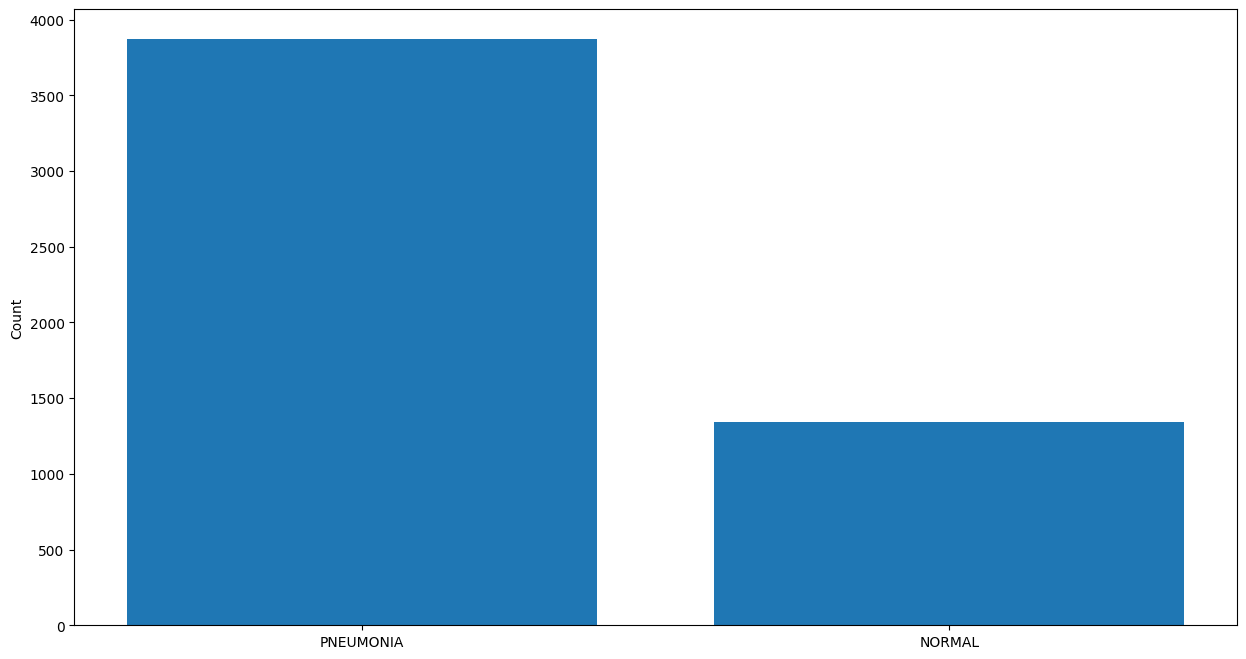

In [171]:

# Count the number of images in each directory
count_normal = len(os.listdir(normal_dir))
count_pneu = len(os.listdir(pneumonia_dir))

# Create a DataFrame with the counts
data = {'Condition': ['PNEUMONIA', 'NORMAL'], 'Count': [count_pneu, count_normal]}
df = pd.DataFrame(data)

plt.figure(figsize=(15, 8))
plt.bar(df['Condition'], df['Count'])
plt.ylabel('Count', fontsize=10)

# Display the plot
plt.show()

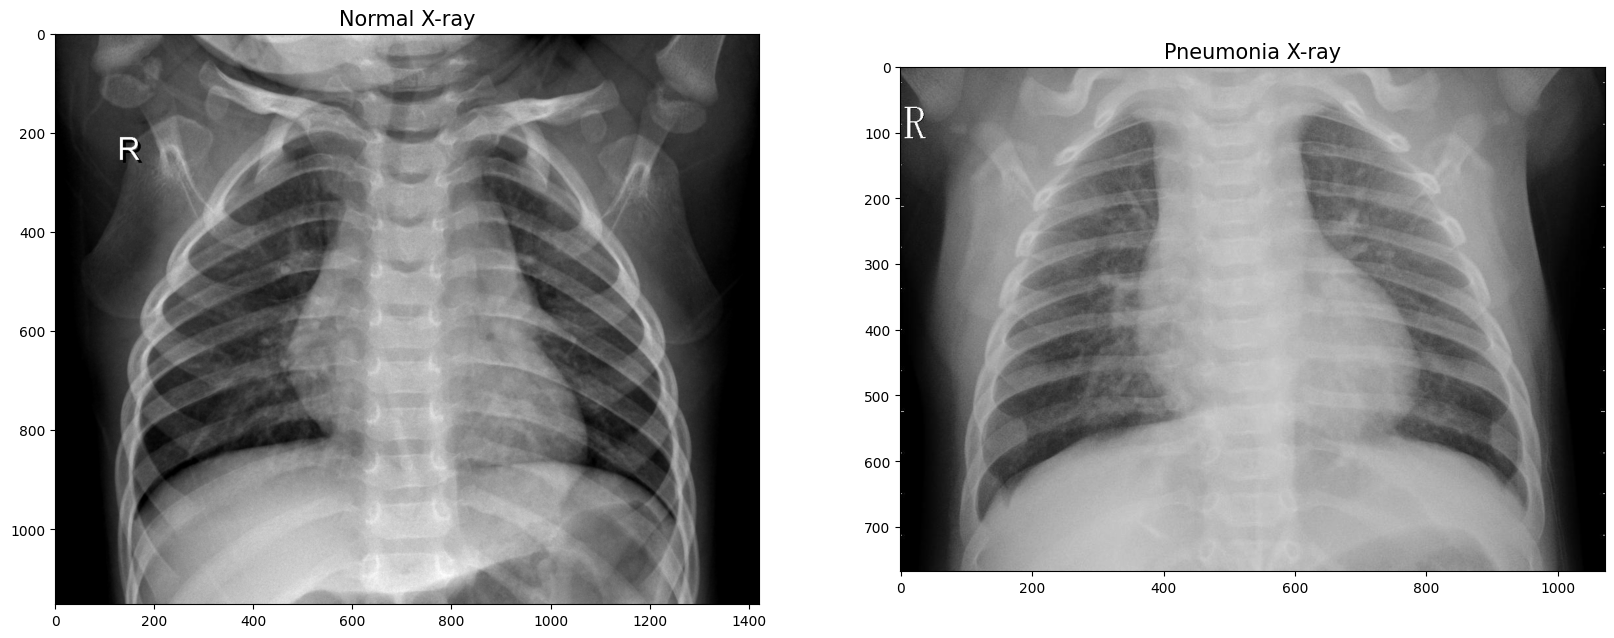

In [172]:
# pull sample of images
# Load the images
normal_img_path = os.path.join(normal_dir, os.listdir(normal_dir)[1])
pneumonia_img_path = os.path.join(pneumonia_dir, os.listdir(pneumonia_dir)[1])

normal = Image.open(normal_img_path)
pneu = Image.open(pneumonia_img_path)

# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

ax1.set_title('Normal X-ray', fontsize=15)
ax1.imshow(normal, cmap='gray')

ax2.set_title('Pneumonia X-ray', fontsize=15)
ax2.imshow(pneu, cmap='gray')

plt.show()

In [173]:
categories = ['PNEUMONIA', 'NORMAL']
image_size = 100

def load_data(directory):
    dataset = []
    for category in categories:
        category_path = os.path.join(directory, category)
        class_label = categories.index(category)
        
        if not os.path.isdir(category_path):
            print(f"Directory {category_path} does not exist.")
            continue
        
        for image in os.listdir(category_path):
            try:
                image_path = os.path.join(category_path, image)
                image_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                
                if image_array is None:
                    print(f"Failed to read image {image_path}. Skipping...")
                    continue
                
                resized_image = cv2.resize(image_array, (image_size, image_size)) # Reshaping images to preferred size
                dataset.append([resized_image, class_label])
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")
    
    return np.array(dataset, dtype=object)

In [174]:
train_dir = 'Resources/train/'
test_dir = 'Resources/test/'
val_dir = 'Resources/val/'

In [175]:
train_data = load_data(train_dir)
test_data = load_data(test_dir)
val_data = load_data(val_dir)

Failed to read image Resources/val/PNEUMONIA\._.DS_Store. Skipping...
Failed to read image Resources/val/NORMAL\._.DS_Store. Skipping...


In [176]:
x_train = []
y_train = []

for feature, label in train_data:
    x_train.append(feature)
    y_train.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)

# Print shapes to verify
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

x_train shape: (5216, 100, 100)
y_train shape: (5216,)


In [177]:
x_test = []
y_test = []

for feature, label in test_data:
    x_test.append(feature)
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Print shapes to verify
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_test shape: (624, 100, 100)
y_test shape: (624,)


In [178]:
x_val = []
y_val = []

for feature, label in val_data:
    x_val.append(feature)
    y_val.append(label)

x_val = np.array(x_val)
y_val = np.array(y_val)

print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

x_val shape: (16, 100, 100)
y_val shape: (16,)


In [179]:
x_train = x_train / 255
x_test = x_test / 255
x_val = x_val / 255

In [180]:
x_train = x_train.reshape(-1, image_size, image_size, 1)
x_test = x_test.reshape(-1, image_size, image_size, 1)
x_val = x_val.reshape(-1, image_size, image_size, 1)

In [181]:
datagenerate = ImageDataGenerator(rotation_range = 30,
                                  shear_range = 0.15,
                                  zoom_range = 0.15,
                                  width_shift_range = 0.15,
                                  height_shift_range = 0.15,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest')


In [182]:
datagenerate.fit(x_train)

In [183]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 1)),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(192, activation='relu'),
    Dense(64, activation = 'relu'),
    Dense(2, activation='softmax')  # Assuming two classes: PNEUMONIA and NORMAL
])

c:\Users\sophi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [184]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [185]:
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.8193 - loss: 0.3744 - val_accuracy: 0.7452 - val_loss: 0.7373
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.9656 - loss: 0.0913 - val_accuracy: 0.7452 - val_loss: 1.0111
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.9765 - loss: 0.0723 - val_accuracy: 0.7628 - val_loss: 1.1493
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.9791 - loss: 0.0516 - val_accuracy: 0.8061 - val_loss: 0.6697
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.9767 - loss: 0.0528 - val_accuracy: 0.7436 - val_loss: 1.5168
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.9879 - loss: 0.0325 - val_accuracy: 0.7196 - val_loss: 1.5763
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.9958 - loss: 0.0158 - val_accuracy: 0.7612 - val_loss: 1.3066
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.9950 - loss: 0.0172 - 

In [186]:
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Convert y_test to binary labels if it's not already in that format
y_test_binary = (y_test > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test_binary, y_pred)

# Precision
precision = precision_score(y_test_binary, y_pred)

# Recall
recall = recall_score(y_test_binary, y_pred)

# F1-score
f1 = f1_score(y_test_binary, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.7692307692307693
Precision: 0.9591836734693877
Recall: 0.4017094017094017
F1-score: 0.5662650602409639


In [187]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


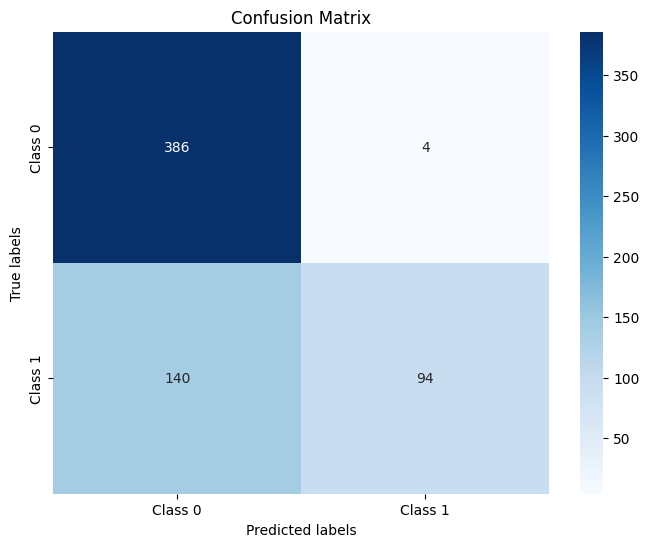

In [188]:
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred)
# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()